# CMSC421 Final Project

Group Memebers: Aron Sun, Jie Zheng, Sean Markey, James Poff //type your name in

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from keras.models import Sequential
from keras.layers import Dense   
from keras import optimizers

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from keras.models import load_model
from keras import optimizers
from matplotlib import pyplot
from math import sqrt
from keras import optimizers
import tensorflow as tf

In [37]:
from datetime import datetime, timedelta
# load the data 
data_frame = pd.read_csv('us-counties.csv')

# Isolate out date for a single
df = data_frame[data_frame.state=='Texas']
df = data_frame.groupby(['date']).sum().reset_index()

# Convert date to a string
df['date'] = df['date'].astype("string")

# Using datetime to convert the date string to a numerical value
d2020 = datetime(year = 2020, month = 1, day = 21)

date_time = []
for i in np.arange(len(df)):
    date = (np.array(df['date'].iloc[i].split('-')))
    time = datetime(int(date[0]),int(date[1]),int(date[2]))
    date_time.append(2020+(time-d2020)/timedelta(days=365.2425))
date_time = np.array(date_time)


In [38]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from numpy import array

# Function that splits the data into input and ouput sequences
def split_seq(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence.iloc[i:end_ix], sequence.iloc[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# split the training and testing data
train_ind = int(len(df)*0.8)
train, test = train_test_split(df['cases'], test_size = 0.2, shuffle=False)
train_date, test_date = train_test_split(date_time, test_size = 0.2, shuffle=False)

# train = df['cases'][:train_ind]
# test = df['cases'][train_ind:]


# define hyperparameters
n_inputs = 1
batch_size = 20
n_features = 1
generator_train = TimeseriesGenerator(train, train, length=n_inputs, batch_size=batch_size)
train_in, train_out = split_seq(train, n_inputs)
test_in, test_out = split_seq(test, n_inputs)
train_out = np.expand_dims(train_out, axis=1)
test_out = np.expand_dims(test_out, axis=1)


In [39]:
# define model
def get_lstm():
  model = Sequential()
  # add hidden layer (LSTM)
  model.add(LSTM(50, activation='relu', input_shape=(n_inputs, n_features)))
  # add output layer
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
  return model

In [40]:
!pip install memory_profiler
%load_ext memory_profiler

print("----------- LSTM MEMORY STATISTICS ------------")
%memit model = get_lstm()


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
----------- LSTM MEMORY STATISTICS ------------
peak memory: 1002.05 MiB, increment: 0.00 MiB


In [41]:
# fit model

%%time
history = model.fit(generator_train,
                    validation_data = (test_in, test_out),
                    steps_per_epoch=1,
                    epochs=500,
                    verbose=0)

train_pred = model.predict(train_in, verbose=0)
test_pred = model.predict(test_in, verbose=0)

print("----------- LSTM TIMING STATISTICS ------------")


----------- LSTM TIMING STATISTICS ------------
CPU times: user 32.8 s, sys: 1.25 s, total: 34 s
Wall time: 38.8 s


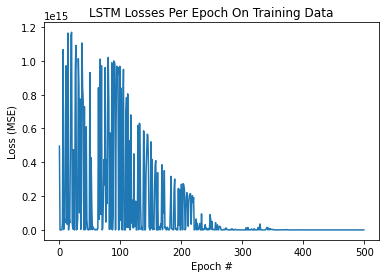

In [42]:
plt.plot(history.history['mean_squared_error'])
plt.title("LSTM Losses Per Epoch On Training Data")
plt.xlabel("Epoch #")
plt.ylabel("Loss (MSE)")
plt.show()

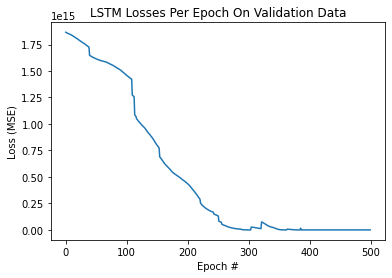

In [43]:
plt.plot(history.history['val_loss'])
plt.title("LSTM Losses Per Epoch On Validation Data")
plt.xlabel("Epoch #")
plt.ylabel("Loss (MSE)")
plt.show()

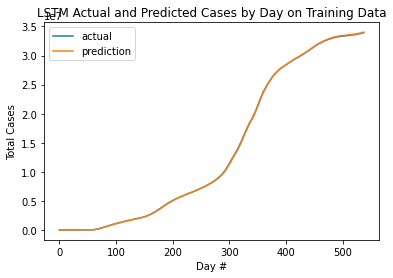

In [44]:
# training set actual vs prediction plot
plt.plot(train_out)
plt.plot(train_pred)

plt.title("LSTM Actual and Predicted Cases by Day on Training Data")
plt.xlabel("Day #")
plt.ylabel("Total Cases")

plt.legend(['actual', 'prediction'])
plt.show()

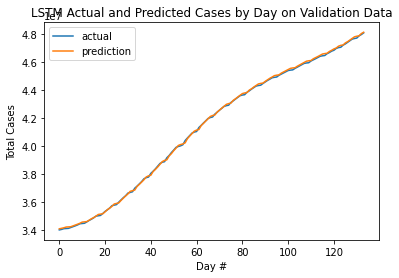

In [45]:
# testing set actual vs prediction plot
plt.plot(test_out)
plt.plot(test_pred)

plt.title("LSTM Actual and Predicted Cases by Day on Validation Data")
plt.xlabel("Day #")
plt.ylabel("Total Cases")

plt.legend(['actual', 'prediction'])
plt.show()

In [46]:
# function for calculating MAE (mean absolute error)
def calc_mae(pred, true):
  if len(pred) != len(true):
    print("Predicted and true arrays must be of equal length!")
    return -1
  
  sum = 0
  for i in range(len(pred)):
    sum += abs(true[i] - pred[i])

  return (sum / len(pred))[0]


In [47]:
lstm_mae = calc_mae(test_pred, test_out)

print(f"Mean Absolute Error (MAE) of LSTM on Validation Data is {lstm_mae:.2f}")

Mean Absolute Error (MAE) of LSTM on Validation Data is 64189.62


In [48]:
# !pip install easyesn
from easyesn import PredictionESN
from easyesn.optimizers import GradientOptimizer
from easyesn.optimizers import GridSearchOptimizer

In [49]:
print("----------- ESN MEMORY STATISTICS ------------")
%memit esn = PredictionESN(n_input=1, n_output=1, n_reservoir=500, leakingRate=0.2, spectralRadius=0.2, regressionParameters=[1e-2], solver="lsqr")

----------- ESN MEMORY STATISTICS ------------
peak memory: 1005.53 MiB, increment: 0.07 MiB


In [50]:
%%time
esn.fit(train_in, train_out, transientTime="Auto", verbose=1)
opt = GradientOptimizer(esn, learningRate=0.001)
validationLosses, fitLosses, inputScalings, spectralRadiuses, leakingRates, learningRates = opt.optimizeParameterForTrainError(train_in, train_out, test_in, test_out, epochs=80, transientTime=100)
print("----------- ESN TIMING STATISTICS ------------")


100% (495 of 495) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 80) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.7/dist-packages/easyesn/PredictionESN.py:41: RuntimeWarning: overflow encountered in square
  activationDerivative=lambda x: 1.0 / B.cosh(x) ** 2,
/usr/local/lib/python3.7/dist-packages/easyesn/PredictionESN.py:41: RuntimeWarning: overflow encountered in cosh
  activationDerivative=lambda x: 1.0 / B.cosh(x) ** 2,
100% (80 of 80) |########################| Elapsed Time: 0:01:26 Time:  0:01:26


----------- ESN TIMING STATISTICS ------------
CPU times: user 2min 7s, sys: 40.8 s, total: 2min 47s
Wall time: 1min 27s


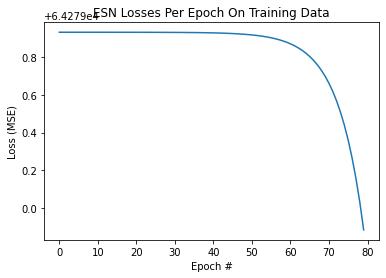

In [51]:
plt.plot(fitLosses)
plt.title("ESN Losses Per Epoch On Training Data")
plt.xlabel("Epoch #")
plt.ylabel("Loss (MSE)")
plt.show()

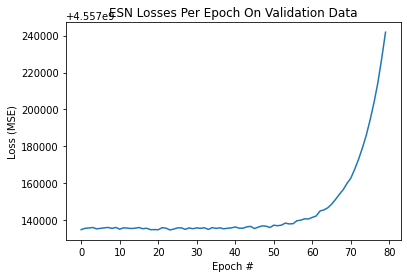

In [52]:
plt.plot(validationLosses)
plt.title("ESN Losses Per Epoch On Validation Data")
plt.xlabel("Epoch #")
plt.ylabel("Loss (MSE)")
plt.show()

In [53]:
y_train_pred = esn.predict(train_in)
y_test_pred = esn.predict(test_in)

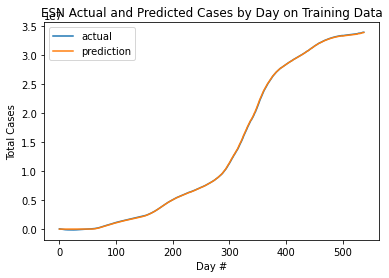

In [54]:
#y_test_pred
plt.plot(y_train_pred)
plt.plot(train_out)

plt.title("ESN Actual and Predicted Cases by Day on Training Data")
plt.xlabel("Day #")
plt.ylabel("Total Cases")

plt.legend(['actual', 'prediction'])
plt.show()

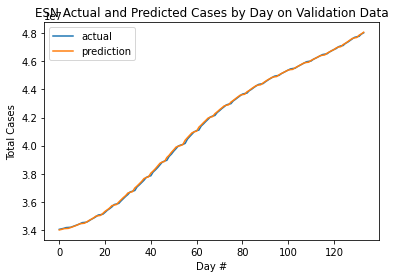

In [55]:
plt.plot(y_test_pred)
plt.plot(test_out)

plt.title("ESN Actual and Predicted Cases by Day on Validation Data")
plt.xlabel("Day #")
plt.ylabel("Total Cases")

plt.legend(['actual', 'prediction'])
plt.show()

In [56]:
esn_mae = calc_mae(y_test_pred, test_out)

print(f"Mean Absolute Error (MAE) of ESN on Validation Data is {esn_mae:.2f}")

Mean Absolute Error (MAE) of ESN on Validation Data is 52269.97
